# Pandeia for WFIRST Imaging

How to cite this code:

> Klaus M. Pontoppidan ; Timothy E. Pickering ; Victoria G. Laidler ; Karoline Gilbert ; Christopher D. Sontag, et al.
"Pandeia: a multi-mission exposure time calculator for JWST and WFIRST", Proc. SPIE 9910, Observatory Operations: Strategies, Processes, and Systems VI, 991016 (July 15, 2016); doi:10.1117/12.2231768; http://dx.doi.org/10.1117/12.2231768

This is an introductory notebook that provides an easy-to-use interface for making Pandeia ETC calculations. This notebook only supports WFIRST imaging and IFU, and has simplified some configuration options.  

Refer to the documentation links provided within the *Help* menu for general information on the Jupyter/IPython notebook interface and useful keyboard short-cuts.  The key things you need to know are that you must use ``Shift-Enter`` to execute a cell and that once a cell is executed, all data defined within it becomes available to all other cells. (You can also click the <i class="fa-step-forward fa"></i> icon in the toolbar to run a cell.)

This first cell sets up the imports and configuration that are required:  

In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import sys
import os
import numpy as np
import matplotlib
from matplotlib import style
#style.use('ggplot')  # see http://matplotlib.org/users/style_sheets.html
                     # for info on matplotlib styles
import json
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
import matplotlib.pyplot as plt

# the first pandeia import is required to run calculations. the others are provided to
# allow setting up calculations and loading/saving of inputs or results.
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import get_telescope_config, get_instrument_config, build_default_calc, build_default_source
from pandeia.engine.io_utils import read_json, write_json

To run Pandeia, you must give it a calculation. Calculations are python dictionaries that specify every aspect of the detector configuration, instrument configuration, details of all of the sources in the scene, and observing strategies.

Let's break it down.

# First, we need to create a default calculation. 

build_default_calc will create a default calculation for a WFIRST instrument, complete with a single faint point source.

build_default_calc() takes three arguments: telescope, instrument, mode.
Telescope is (obviously) wfirst.
Instrument is either wfirstimager or wfirstifu
The only mode available for wfirstimager is "imaging"; the only mode available for wfirstifu is "ifu".

In [2]:
calc = build_default_calc('wfirst','wfirstimager','imaging')

This is a complete calculation, so we can run it. Try the following, and if it doesn't work, check your setup.

In [3]:
result = perform_calculation(calc)

# Now we have a default calculation. Let's customize.

The first thing we need to do is customize the scene. The default that's been created for us is a single central point source with a flat spectral energy distribution, normalized to a flux of 0.01 mjy at 2.0 microns, with no redshift or extinction.


In [4]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.01 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "at_lambda"

The type of flux normalization can be changed. Run the cell below to normalize to a bandpass
- Valid bandpasses are:
   - bessel,J (or H or K)
   - cousins,I
   - johnson,V (or I, J, K)
   - sdss,u (or g, r, i, or z)
   - spitzer,irac3.6 (or irac4.5, irac5.8, irac8.0, mips24)
- You can also specify 'jwst' or 'hst' instead of 'photsys'; that requires specifying the instrument, mode, and filter though ('hst' and 'wfc3,ir,f140w', or 'jwst' and 'miri,imaging,f1280w'...)
   

In [5]:
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = 0.01 # mjy
calc['scene'][0]['spectrum']['normalization']['norm_wave'] = 2.0 # microns
calc['scene'][0]['spectrum']['normalization']['type'] = "photsys"
calc['scene'][0]['spectrum']['normalization']['bandpass'] = "sdss,z"

There are also other options for the SED, most notably a simple blackbody curve, or phoenix models, or one of the Brown galaxy spectra.

Run one of the following cells if you want to customize your source to a different SED type: 

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'blackbody' # shape
calc['scene'][0]['spectrum']['sed']['temp'] = 5770.0 # brightness temperature

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'phoenix' # shape
calc['scene'][0]['spectrum']['sed']['temp'] = 5770.0 # brightness temperature

In [ ]:
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'brown' # shape
calc['scene'][0]['spectrum']['sed']['key'] = 'ngc_3521' # galaxy profile

We can also change the shape of the source. Valid options are 'point', 'gaussian2d', 'sersic', and 'flat'. 

'point' is a point source, represented as a simple impulse function to convolve with the PSF.
'flat' is an ellipse step function, with a uniform distribution out to the bounding curve.
'gaussian2d' is a two-dimensional gaussian function, where major and minor are now the 1-sigma boundaries.
'sersic' is NOT the typical sersic formulation from Graham & Driver (1992); it is an e-folding version, defined as e^{-r{1/index}}. index=4 is the standard De Vaucoulers profile, index 0.5 is similar to a gaussian, and index=1 is an exponential profile.

If you change the shape to gaussian2d, flat, or sersic, you have additional parameters to fill. In particular, there are options to change how you set the source brightness:
 - 'integ_infinity' Integrates the flux of the entire profile
 - 'surf_center' Normalizes to the surface brightness at the center of the profile
 - 'surf_scale' Normalizes to the surface brightness at the scale (e-folding for sersic, 1-sigma for gaussian2d) radius. You cannot choose this for the flat source.
If you choose surf_center or surf_scale, you need to specify whether the brightness is per square arcsecond ('arcsec^2') or steradians ('sr')

In [ ]:
calc['scene'][0]['shape']['geometry'] = 'point'

In [ ]:
calc['scene'][0]['shape']['geometry'] = 'gaussian2d'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'integ_infinity'
calc['scene'][0]['shape']['surf_area_units'] = None

In [29]:
calc['scene'][0]['shape']['geometry'] = 'flat'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['norm_method'] = 'surf_center'
calc['scene'][0]['shape']['surf_area_units'] = 'arcsec^2'

In [6]:
calc['scene'][0]['shape']['geometry'] = 'sersic'
calc['scene'][0]['shape']['major'] = 0.5 # arcsec
calc['scene'][0]['shape']['minor'] = 0.2 # arcsec
calc['scene'][0]['shape']['sersic_index'] = 1.0
calc['scene'][0]['shape']['norm_method'] = 'surf_scale'
calc['scene'][0]['shape']['surf_area_units'] = 'sr'

We can also position the source: (though orientation obviously means little to a point source)

In [7]:
calc['scene'][0]['position']['x_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['y_offset'] = 0.0 # arcsec
calc['scene'][0]['position']['orientation'] = 45.0 # degrees

You can also add other sources, and customize them.

In [ ]:
calc['scene'].append(build_default_source(geometry="point"))

# Now let's set up the instrument

For the WFIRST Imager:

- Filters (For the WFIRST imager)
   - z087 (Z-band 0.87 microns) - the default
   - y106 (Y-band 1.06 microns)
   - j129 (J-band 1.29 microns)
   - w149 (w-band 1.49 microns)
   - h158 (H-band 1.58 microns)
   - f184 (f-band 1.84 microns)
   
There are no valid dispersive elements, and only one aperture: 'any'.

The detector can be configured to give multiple exposures in multiple groups and integrations, and set the readmode. For the WFIRST imager, there are a number of readmodes:

- Readmodes:
   - 'rapid'
   - 'shallow2'
   - 'shallow4'
   - 'bright1'
   - 'bright2'
   - 'medium2'
   - 'medium8'
   - 'deep2' - the default
   - 'deep8'

- And a number of subarrays:
   - '32x32'
   - '64x64'
   - '128x128'
   - '256x256'
   - '512x512'
   - '1024x1024'
   - '1024x16'
   - 'full' (4096x4096) - the default

In [8]:
calc['configuration']['instrument']['filter'] = "z087"
calc['configuration']['instrument']['apertures'] = "any"
calc['configuration']['instrument']['dispersers'] = None
calc['configuration']['detector']['ngroup'] = 10 # groups per integration
calc['configuration']['detector']['nint'] = 10 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "rapid"
calc['configuration']['detector']['subarray'] = "full"

For the WFIRST IFU, there is much less to configure.
The only valid filter is "clear", to be used with the "prism" disperser in the "ifu" aperture, and "full" subarray. You can select between 'nrs' (the default) and 'nrsrapid' readmodes

In [ ]:
calc['configuration']['instrument']['filter'] = "clear"
calc['configuration']['instrument']['apertures'] = "ifu"
calc['configuration']['instrument']['dispersers'] = "prism"
calc['configuration']['detector']['ngroup'] = 10 # groups per integration
calc['configuration']['detector']['nint'] = 10 # integrations per exposures
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "nrs"
calc['configuration']['detector']['subarray'] = "full"

# We can now set the strategy. 

For the WFIRST imager, the only potential option is to modify the target source and target location to point to a source that's been offset.

In [11]:
calc['strategy']['target_source'] = 1
calc['strategy']['target_xy'] = [0.0,0.0]

For WFIRST IFU, there are three different observation strategies:
    - 'ifuapphot': IFU Aperture Photometry - the default
    - 'ifunodinscene': IFU Nod (in-scene)
    - 'ifunodoffscene': IFU Nod (off-scene)
    
For the IFU nod modes, you can set the dithers. For ifunodinscene, the values should be small- less than 5 arcsec. For ifunodinscene, it should be more than 10 arcsec. Note that we don't currently shift to add the dithers; this is a limitation of Pandeia as it currently stands. 

In [ ]:
calc['strategy']['target_source']['method'] = 'ifunodinscene'
calc['strategy']['target_source']['target_source'] = 1
calc['strategy']['target_source']['target_xy'] = [0.0,0.0]
calc['strategy']['target_source']['dithers'] = [{'x':0.0,'y':0.0},{'x':1.0,'y':1.0}]

# Calculate!

Still with us? We now have a formatted calculation we can run, so let's do that.

In [30]:
results = perform_calculation(calc)
fits = perform_calculation(calc,dict_report=False)

Let's unpack all the results.  Run the following to see the basic outputs - flux, SNR, exposure time, etc.

In [31]:
for x in results['scalar'].keys():
   print("{0:}: {1:}".format(x,results['scalar'][x]))

exposure_time: 1169.3
aperture_size: 0.2
cr_ramp_rate: 0.0026034843276
reference_wavelength: 0.858052666833
extraction_area: 10.3854302598
all_dithers_time: 1169.3
total_integrations: 10
saturation_time: 106.3
measurement_time: 956.7
sn: 864.523406035
extracted_noise: 4.04899682385
extracted_flux: 3500.45252518
duty_cycle: 0.818181818182
background: 0.140574041163
contamination: 0.991731079105
background_sky: 2.19652589227
disperser: None
filter: z087
y_offset: 0.0
x_offset: 0.0
background_area: 51.927151299
background_total: 265.636341203
total_exposure_time: 1169.3


Let's also look at some plots. Here are the detector SNR, signal, and saturation

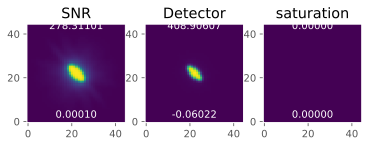

In [32]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(131)
ax2 = fig1.add_subplot(132)
ax3 = fig1.add_subplot(133)
ax1.imshow(results['2d']['snr'])
ax2.imshow(results['2d']['detector'])
ax3.imshow(results['2d']['saturation'])
ax1.set_title('SNR')
ax2.set_title('Detector')
ax3.set_title('Saturation')
ax1.text(0.5,0.95,'{0:6.5f}'.format(np.max(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax1.text(0.5,0.05,'{0:6.5f}'.format(np.min(results['2d']['snr'])),horizontalalignment='center',transform=ax1.transAxes,color='#FFFFFF')
ax2.text(0.5,0.95,'{0:6.5f}'.format(np.max(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax2.text(0.5,0.05,'{0:6.5f}'.format(np.min(results['2d']['detector'])),horizontalalignment='center',transform=ax2.transAxes,color='#FFFFFF')
ax3.text(0.5,0.95,'{0:6.5f}'.format(np.max(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')
ax3.text(0.5,0.05,'{0:6.5f}'.format(np.min(results['2d']['saturation'])),horizontalalignment='center',transform=ax3.transAxes,color='#FFFFFF')

We can also see some 1D plots. They won't look like much in Imager mode.

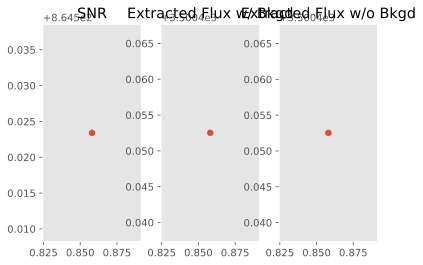

In [44]:
fig2 = plt.figure()
ax1 = fig2.add_subplot(131)
ax2 = fig2.add_subplot(132)
ax3 = fig2.add_subplot(133)
if len(results['1d']['sn'][0]) == 1:
    ax1.scatter(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.scatter(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
    ax3.scatter(results['1d']['extracted_flux'][0],results['1d']['extracted_flux'][1])
else:
    ax1.plot(results['1d']['sn'][0],results['1d']['sn'][1])
    ax2.plot(results['1d']['extracted_flux_plus_bg'][0],results['1d']['extracted_flux_plus_bg'][1])
    ax3.plot(results['1d']['extracted_flux'][0],results['1d']['extracted_flux'][1])
ax1.set_title('SNR')
ax2.set_title('Extracted Flux w/ Bkgd')
ax3.set_title('Extracted Flux w/o Bkgd')

If you want to save your calculation, you can run the next cell, and copy that into a file:

In [45]:
print(json.dumps(calc, sort_keys=True, indent=4, separators=(',', ': ')))

{
    "background": "medium",
    "calculation": {
        "effects": {
            "background": true,
            "ipc": true,
            "saturation": true
        },
        "noise": {
            "crs": true,
            "darkcurrent": true,
            "ffnoise": true,
            "readnoise": true,
            "rn_correlation": true
        }
    },
    "configuration": {
        "detector": {
            "nexp": 1,
            "ngroup": 10,
            "nint": 10,
            "readmode": "rapid",
            "subarray": "full"
        },
        "dynamic_scene": true,
        "instrument": {
            "aperture": "any",
            "apertures": "any",
            "disperser": null,
            "dispersers": null,
            "filter": "z087",
            "instrument": "wfirstimager",
            "mode": "imaging"
        },
        "max_scene_size": 25,
        "scene_size": 5
    },
    "scene": [
        {
            "position": {
                "orientation": 45.0,
    